In [1]:
import astropy as ast
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation, GeocentricTrueEcliptic, get_body, SkyCoord
import jdcal # for conversion to Julian day
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# For visualization/plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import plot_confusion_matrix
register_matplotlib_converters()

In [3]:
# For surpressing future warnings and similar warnings not impacting functionality
import warnings

In [4]:
# For classification models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

In [5]:
# For regression models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
import fbprophet

## Data Wrangling

This code handles data generation (if needed) and otherwise prepares data for prediction by loading from `.csv` files. Basic visualization is also done here.

In [6]:
GENERATE_DATA = False # set GENERATE_DATA to True to generate data again. May take ~1h or more depending on processing power

In [7]:
def to_isoformat(date):
    date = date.split()
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    months = dict(zip(months, range(1, 13)))
    return '%s-%d-%s' % (date[0], months[date[1]], date[2])
        

In [8]:
if GENERATE_DATA:
    data = pd.read_csv('solar_eclipse_data.csv')

    # Select for years between 1900AD and 2100AD (to maintain accuracy of astropy data)
    # years_to_keep = data['Calendar Date'].str.split().apply(lambda x: x[0]).apply(lambda x: int(x) >= 1900 and int(x) <= 2050)
    # Select for years >= 0
    years_to_keep = data['Calendar Date'].str.split().apply(lambda x: x[0]).apply(lambda x: int(x) >= 0)
    data = data[years_to_keep]

    # Convert to ISO dates
    data['ISO Date'] = data['Calendar Date'] + ' ' + data['Eclipse Time']
    data['ISO Date'] = data['ISO Date'].apply(lambda x: to_isoformat(x))
    data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))
    data.head()

In [9]:
# All of the celestial bodies to generate synthetic data for
BODY_NAMES = ['moon', 'sun']

# Location is the Medicina Radio Observatory, located in Italy. Chosen for proximity to Greece
LOCATION = EarthLocation.of_site('medicina')

In [10]:
def get_coordinates(body):
    # Takes a Skycoord object, returns (theta, phi) in (deg, deg)
    angles = [float(i) for i in body.to_string().split(' ')]
    
    phi = angles[0]
    theta = angles[1]
    return phi, theta

def get_coordinate_rows(times):
    rows = defaultdict(list)
    for time in times:
        print(time)
        bodies = []

        with solar_system_ephemeris.set('builtin'):
            for body_name in BODY_NAMES:
                bodies.append(get_body(body_name, time, LOCATION))

        rows['time'].append(time)
        rows['location'].append(str(LOCATION))

        for body_name, body in zip(BODY_NAMES, bodies):
            theta, phi = get_coordinates(body)
            ecliptic = SkyCoord(theta, phi, frame='gcrs', unit=('deg', 'deg')).transform_to(GeocentricTrueEcliptic())
            coordinates = get_coordinates(ecliptic)
            coord_strings = ['theta', 'phi']

            for i in range(len(coord_strings)):
                c = coordinates[i]
                rows[body_name + '_' + coord_strings[i]].append(c)
    return rows

def convert_latitude(latitude):
    if latitude[-1] == 'N':
        return float(latitude[:-1])
    elif latitude[-1] == 'S':
        return -float(latitude[:-1])
    else:
        raise ValueError
        
def convert_longitude(longitude):
    if longitude[-1] == 'E':
        return float(longitude[:-1])
    elif longitude[-1] == 'W':
        return -float(longitude[:-1])
    else:
        raise ValueError

In [11]:
if GENERATE_DATA:
    times = data['ISO Date']
    rows = get_coordinate_rows(times)
    for k in rows.keys():
        data[k] = rows[k]

    data['latitude'] = data['Latitude'].apply(lambda x: convert_latitude(x))
    data['longitude'] = data['Longitude'].apply(lambda x: convert_longitude(x))
    data = data[['ISO Date', 'longitude', 'latitude', 'moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']]
    data['eclipse'] = 1
    data.to_csv('solar_eclipse_pos_data.csv', index=False)
else:
    data = pd.read_csv('solar_eclipse_pos_data.csv')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

In [12]:
if GENERATE_DATA:
    # Generate the negative samples, i.e. times at which an eclipse is not occuring
    times = []
    for i in range(1, len(data)):
        # Difference in days
        days_difference = data['ISO Date'][i] - data['ISO Date'][i - 1]
        offset = 1
        # Enforce that datapoints in the non-eclipse class are sufficiently distant from datapoints in the eclipse class
        while offset < days_difference - 1:
            offset += abs(np.random.normal(5, 2))
            time = data['ISO Date'][i - 1] + offset
            times.append(time)

    rows = get_coordinate_rows(times)

    negative_data = pd.DataFrame(rows)
    negative_data['eclipse'] = 0
    negative_data.rename(columns={'time':'ISO Date'}, inplace=True)
    negative_data = negative_data.drop(columns='location')
    negative_data.to_csv('solar_eclipse_neg_data.csv', index=False)
else:
    negative_data = pd.read_csv('solar_eclipse_neg_data.csv')
negative_data['ISO Date'] = negative_data['ISO Date'].apply(lambda x: Time(x))

In [13]:
pd.read_csv('solar_eclipse_final_data.csv')

,ISO Date,eclipse,moon_phi,moon_theta,sun_phi,sun_theta
0,1900-05-28T14:53:56.000,1,0.007682,67.5568,0.011563,68.1689
1,1900-11-22T07:19:43.000,1,-0.817203,241.6440,-0.013417,240.9370
2,1901-05-18T05:33:48.000,1,-1.154280,58.4661,0.009681,57.9427
3,1901-11-11T07:28:21.000,1,-0.132481,230.2360,-0.012132,229.5880
4,1902-04-08T14:05:06.000,1,1.111810,18.6202,0.004258,19.1625
...,...,...,...,...,...,...
11398,2050-10-25T11:44:07.100,0,4.220330,327.9850,0.002098,211.5460
11399,2050-11-02T06:20:35.647,0,-3.883710,79.7995,0.003541,219.3100
11400,2050-11-07T21:10:15.269,0,-5.448380,151.7300,0.003594,224.9350
11401,2050-11-12T00:10:51.993,0,-2.218620,200.7720,0.004564,229.0810


In [14]:
if GENERATE_DATA:
    data = data.drop(columns=['longitude', 'latitude']) # Drop the longitude and latitude from the positive dataset, as they are undefined for the negative dataset
    data = pd.concat([data, negative_data], sort=True)
    data.to_csv('solar_eclipse_final_data.csv', index=False)
else:
    data = pd.read_csv('solar_eclipse_final_data.csv')
data = data.sort_values('ISO Date')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

In [15]:
# Plot to understand the data
def plot_parameter(param, n):
    with warnings.catch_warnings(): # Ignore warnings about dubious date for astropy, and pandas future multi-indexing warning
        warnings.simplefilter("ignore")
        positive = data[data['eclipse'] == 1]
        negative = data[data['eclipse'] == 0]

        fig, ax = plt.subplots()
        dates = [pd.to_datetime(d.value.split('T')[0]) for d in positive['ISO Date'][:n]]
        pos = plt.plot_date(dates, positive[param][:n], label='eclipse=1')
        dates = [pd.to_datetime(d.value.split('T')[0]) for d in negative['ISO Date'][:n]]
        neg = plt.plot_date(dates, negative[param][:n], label='eclipse=0')
        date_form = DateFormatter("%Y-%m-%d")
        ax.set_title('%s vs. date' % param)
        ax.xaxis_date()
        ax.xaxis.set_major_formatter(date_form)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=120))
        plt.legend()
        plt.show()

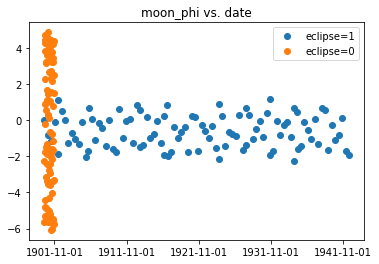

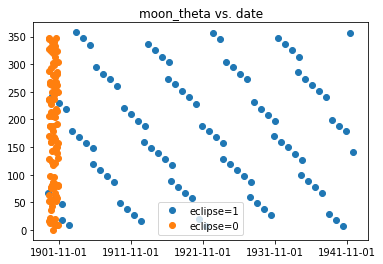

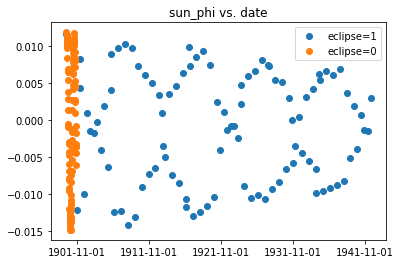

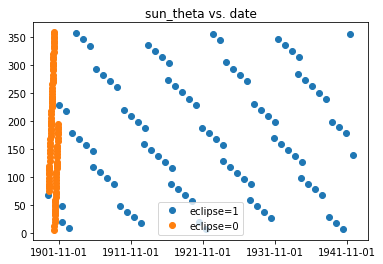

In [16]:
plot_parameter('moon_phi', 100)
plot_parameter('moon_theta', 100)
plot_parameter('sun_phi', 100)
plot_parameter('sun_theta', 100)

## Eclipse Incidence Prediction

This code handles model initialization, training and prediction to answer: "given a time and the position of the moon and sun, is an eclipse occuring?"

In [17]:
data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']]

,moon_theta,moon_phi,sun_theta,sun_phi
0,67.5568,0.007682,68.1689,0.011563
340,169.7330,-5.633400,75.7990,0.011839
341,235.9580,-2.253330,81.0912,0.010925
342,288.6440,2.244950,84.8324,0.010904
343,345.8550,4.409460,88.6735,0.011038
...,...,...,...,...
11399,79.7995,-3.883710,219.3100,0.003541
11400,151.7300,-5.448380,224.9350,0.003594
11401,200.7720,-2.218620,229.0810,0.004564
339,231.3670,0.112373,231.6510,0.003569


In [18]:
X = np.array(data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']])
X = np.append(X, [[d.jd] for d in data['ISO Date']], axis=1)
y = np.array(data['eclipse'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train = X_train + np.random.normal(0, 0.1, size=X_train.shape) additive Gaussian noise

In [19]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [KNeighborsClassifier(3),
    SVC(kernel="sigmoid", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

classifiers = dict(zip(names, classifiers))

In [20]:
print('Selecting best classifier by test score')
best_clf = (None, None)
best_test_score = float('-inf')
for name, clf in classifiers.items():
    print('Training %s classifier' % name)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    if test_score > best_test_score: # Select top-performing classifier by test score
        best_clf = (name, clf)
        best_test_score = test_score
print('\nBest classifier by test score:', best_clf[0])
print('Train score:', best_clf[1].score(X_train, y_train))
print('Test score:', best_clf[1].score(X_test, y_test))

Selecting best classifier by test score
Training Nearest Neighbors classifier
Training Linear SVM classifier
Training RBF SVM classifier
Training Decision Tree classifier
Training Random Forest classifier
Training Neural Net classifier
Training AdaBoost classifier
Training Naive Bayes classifier
Training QDA classifier

Best classifier by test score: QDA
Train score: 0.9979171234378426
Test score: 0.9991231915826392


Confusion matrix (non-normalized)


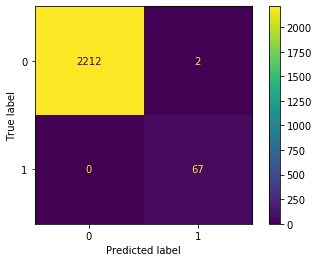

In [21]:
print('Confusion matrix (non-normalized)')
plot_confusion_matrix(best_clf[1], X_test, y_test)
plt.show()

Confusion matrix (normalized across predictions)


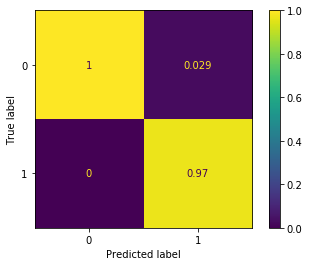

In [22]:
print('Confusion matrix (normalized across predictions)')
plot_confusion_matrix(best_clf[1], X_test, y_test, normalize='pred')
plt.show()

Grid search cross-validation on QDA classifier
Train score: 0.9979171234378426
Test score: 0.9991231915826392
Best reguliarization parameter: 1e-06


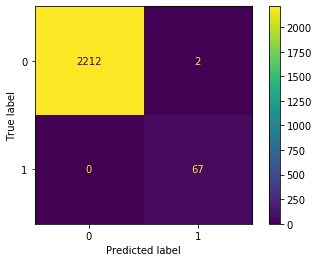

In [23]:
print('Grid search cross-validation on QDA classifier')
params = [{'reg_param': np.arange(0, 0.00001, 0.000001)}]
qda = QuadraticDiscriminantAnalysis()
clf = GridSearchCV(qda, params)
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)
print('Train score:', clf.score(X_train, y_train))
print('Test score:', clf.score(X_test, y_test))
print('Best reguliarization parameter:', clf.best_params_['reg_param'])

## Eclipse Location Prediction

This code handles model initialization, training and prediction to answer: "given a time that an eclipse is occuring, the position of the moon, the position of the sun, where on Earth is the eclipse visible?"

### Latitude Prediction

We will start with making predictions on the latitude.

In [24]:
def to_jd(calendar_date, time=None):
    month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    months = dict(zip(month_labels, range(1, 13)))
    try:
        jd = sum(jdcal.gcal2jd(calendar_date[0], months[calendar_date[1]], calendar_date[2]))
    except KeyError: # if the month is already an integer 
        jd = sum(jdcal.gcal2jd(calendar_date[0], int(calendar_date[1]), calendar_date[2]))
    if time:
        hour, minute, second = time.split(':')
        jd += (int(hour) + int(minute)/60 + int(second)/3600)/24
    return jd

In [25]:
data = pd.read_csv('solar_eclipse_pos_data.csv')
X = data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']]
X = pd.concat([X, data['ISO Date'].str.split('T').apply(lambda x: to_jd(x[0].split('-')))], axis=1)
y = data[['latitude']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train = X_train + np.random.normal(0, 0.1, size=X_train.shape) additive Gaussian noise

In [26]:
def test_regressor(reg, X_train, X_test, y_train, y_test):
    reg.fit(X_train, y_train)
    plt.subplots(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    print('Training score:', reg.score(X_train, y_train))
    plt.scatter(y_train, reg.predict(X_train))
    plt.title('Predicted values vs. true values, training set')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    
    plt.subplot(1, 2, 2)
    print('Test score:', reg.score(X_test, y_test))
    plt.scatter(y_test, reg.predict(X_test))
    plt.title('Predicted values vs. true values, test set')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.tight_layout()
    plt.show()
    
def test_all_regressors(X_train, X_test, y_train, y_test):
    poly = PolynomialFeatures(degree=7)
    X_train_aug = poly.fit_transform(X_train)
    X_test_aug = poly.fit_transform(X_test)

    print('Linear regressor (with polynomial lifted features)')
    test_regressor(LinearRegression(), X_train_aug, X_test_aug, y_train, y_test)

    print('Random Forest Regressor')
    test_regressor(RandomForestRegressor(n_estimators=50), X_train, X_test, np.array(y_train).ravel(), np.array(y_test).ravel())
    
    print('Ridge regression (with cross-validated hyperparameter alpha)')
    test_regressor(RidgeCV(alphas=np.arange(0.1,100,0.1), fit_intercept=True), X_train, X_test, y_train, y_test)

Linear regressor (with polynomial lifted features)
Training score: 0.9335694940533183
Test score: 0.9248092000742517


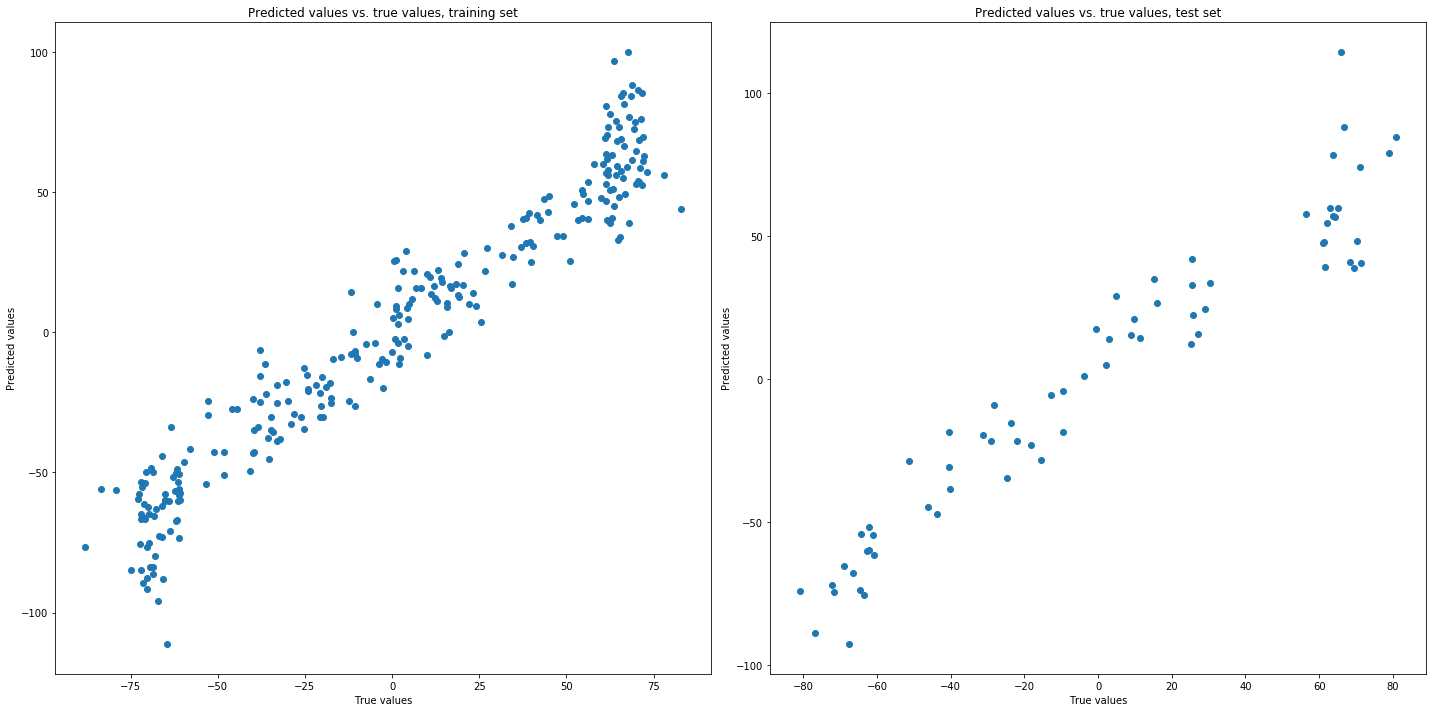

Random Forest Regressor
Training score: 0.9905513817533977
Test score: 0.9245445423728714


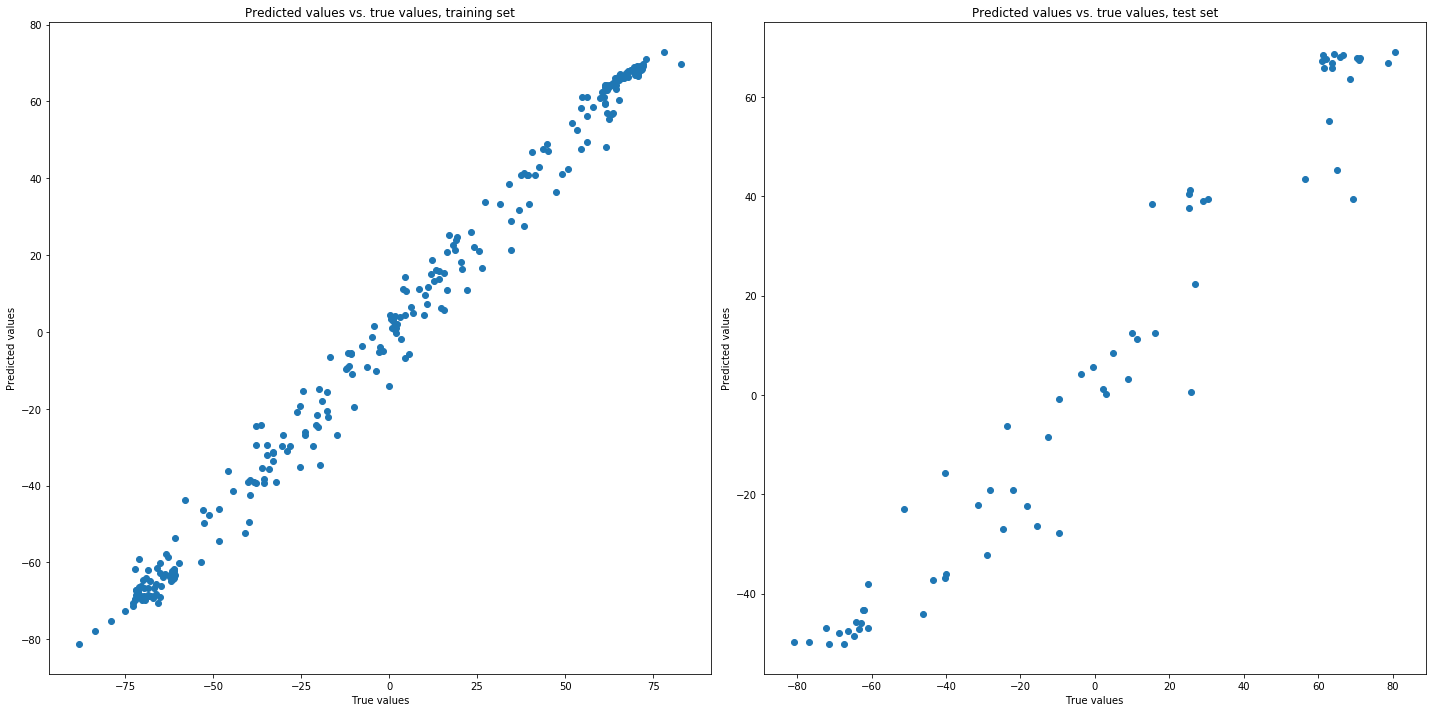

Ridge regression (with cross-validated hyperparameter alpha)
Training score: 0.8881713777036567
Test score: 0.905915359161906


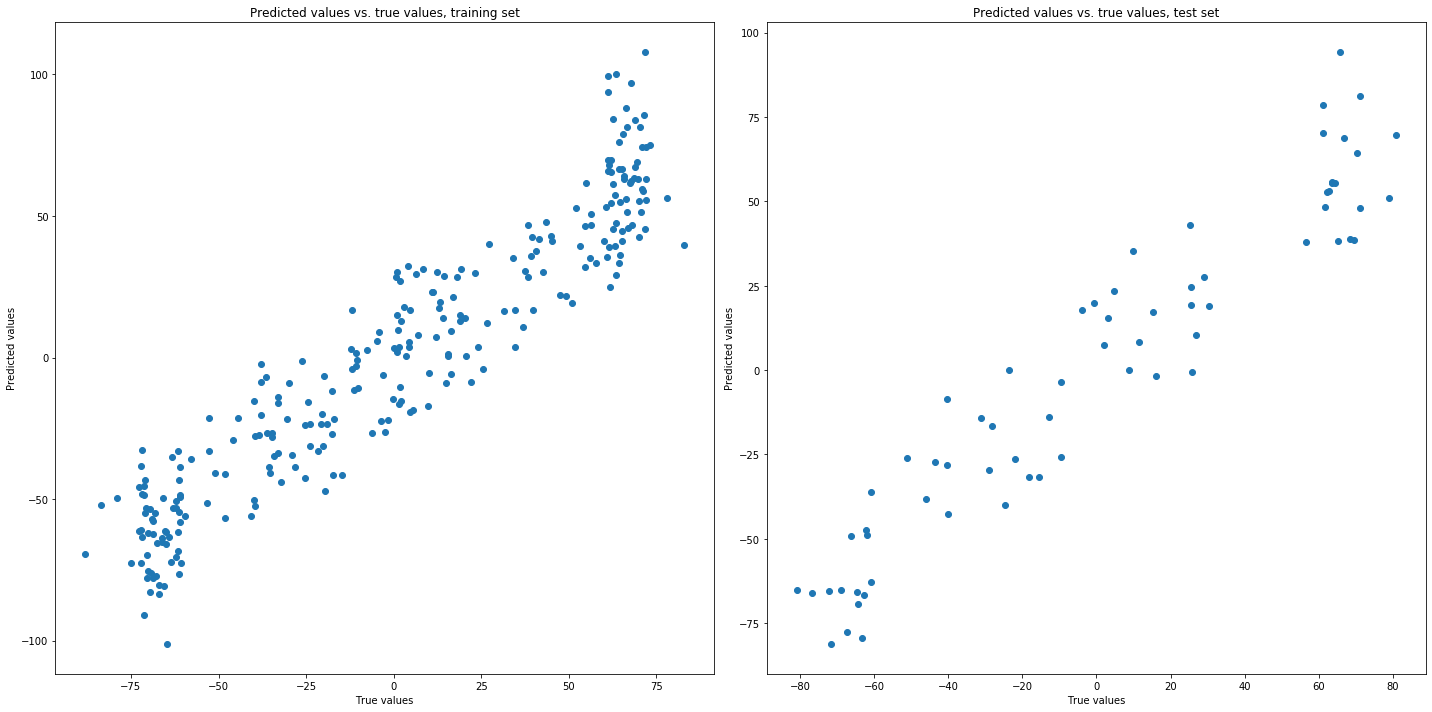

In [27]:
test_all_regressors(X_train, X_test, y_train, y_test)

### Longitude Prediction

Now, let's make predictions on the longitude.

It looks like we can achieve reasonable performance when predicting an eclipse's latitude. Let's see what happens when we do the same for longitude.

In [28]:
# X remains the same, y is now longitude instead of latitude.
y = data[['longitude']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Linear regressor (with polynomial lifted features)
Training score: 0.2702708846611003
Test score: 0.014967526622786553


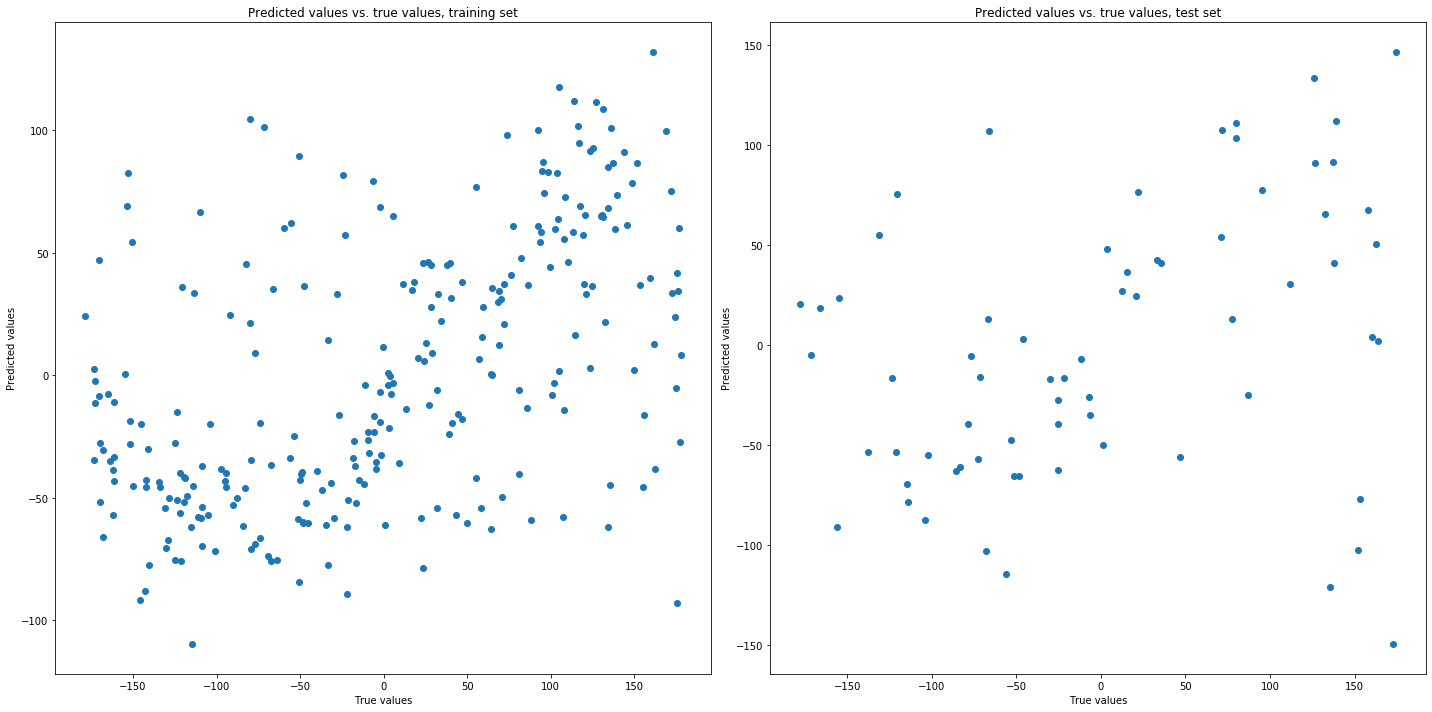

Random Forest Regressor
Training score: 0.8215696269182167
Test score: -0.195771985149652


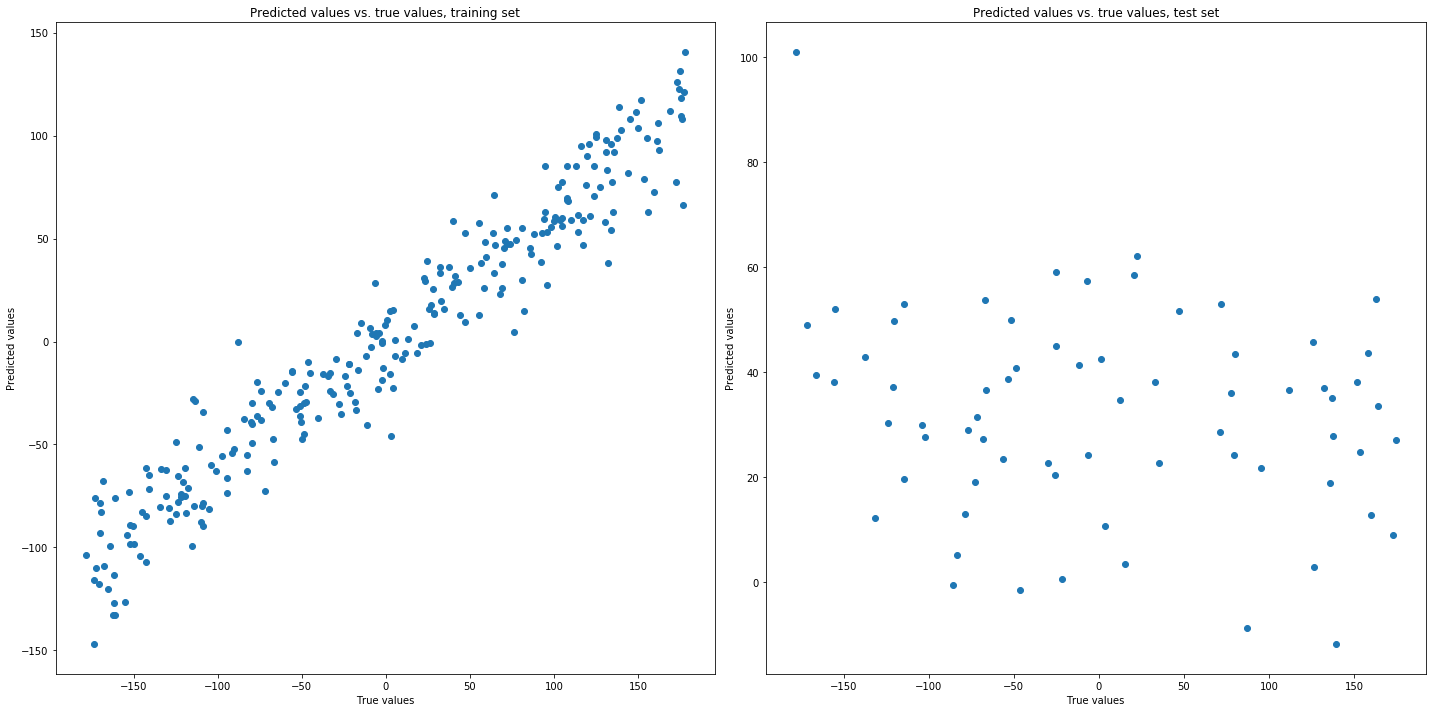

Ridge regression (with cross-validated hyperparameter alpha)
Training score: 0.17992493214016902
Test score: 0.17001799874055745


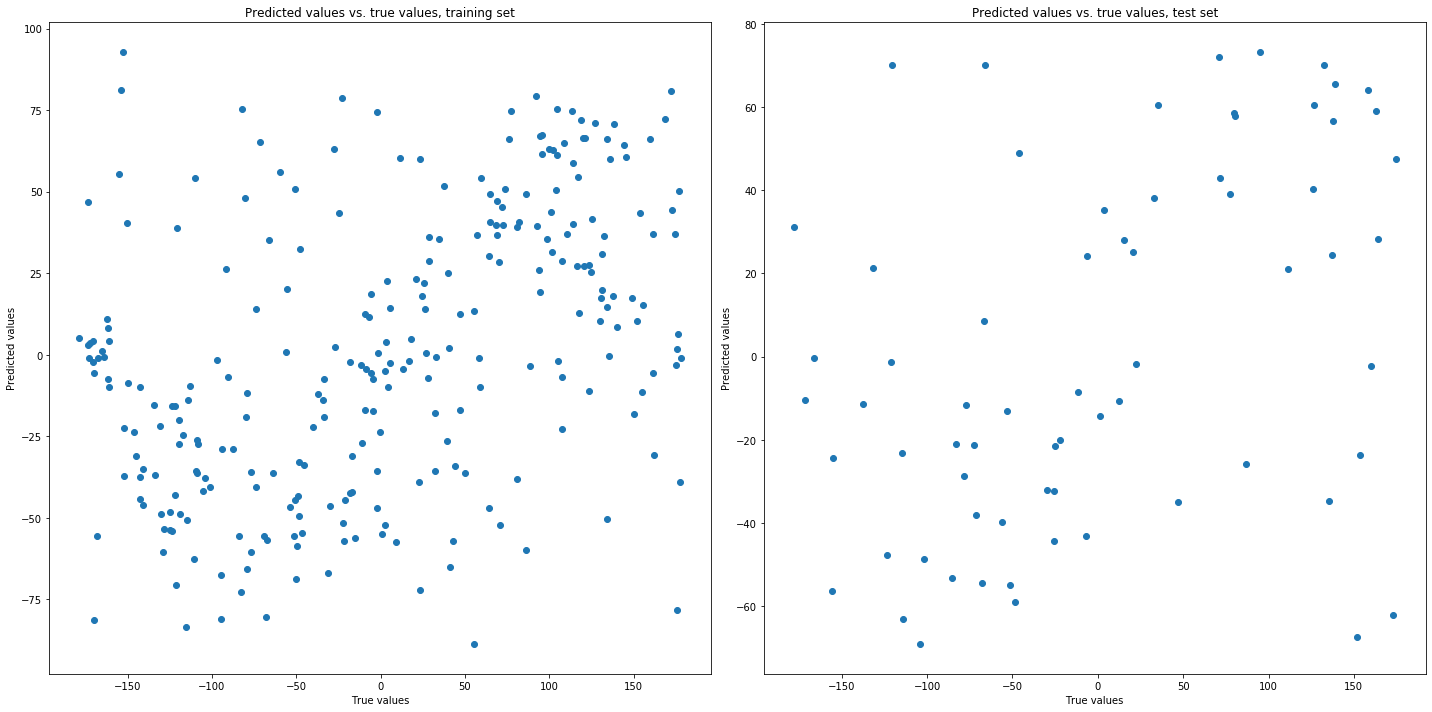

In [29]:
test_all_regressors(X_train, X_test, y_train, y_test)

The performance has now dropped significantly. Why is this the case? We refer to these visualizations.

In [30]:
def plot_locations(data):
    dates = data['Calendar Date'].str.split().apply(lambda calendar_date: to_jd(calendar_date))
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.xlabel('Julian Day')
    plt.ylabel('Latitude')
    plt.title('Latitude vs. Julian Day')
    plt.scatter(dates, data['Latitude'])
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.xlabel('Julian Day')
    plt.ylabel('Longitude')
    plt.title('Longitude vs. Julian Day')
    plt.scatter(dates, data['Longitude'])
    
def plot_saros(data, n):
    saros = data[data['Saros Number'] == n]
    dates = saros['Calendar Date'].str.split().apply(lambda x: int(x[0]))
    plt.subplots(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.xlabel('Year')
    plt.ylabel('Latitude')
    plt.title('Latitude vs. Year, Saros %d' % n)
    plt.scatter(dates, saros['Latitude'])

    plt.subplot(1, 2, 2)
    plt.xlabel('Year')
    plt.ylabel('Longitude')
    plt.title('Longitude vs. Year, Saros %d' % n)
    plt.scatter(dates, saros['Longitude'])
    plt.show()
    
def plot_saros_3rd_eclipses(data, n):
    # Plot every 3rd eclipse in Saros n
    data = data[data['Saros Number'] == n]
    data = data.iloc[::3, :]
    plot_saros(data, n)

In [31]:
data = pd.read_csv('solar_eclipse_data.csv')
data['Latitude'] = data['Latitude'].apply(lambda x: convert_latitude(x))
data['Longitude'] = data['Longitude'].apply(lambda x: convert_longitude(x))

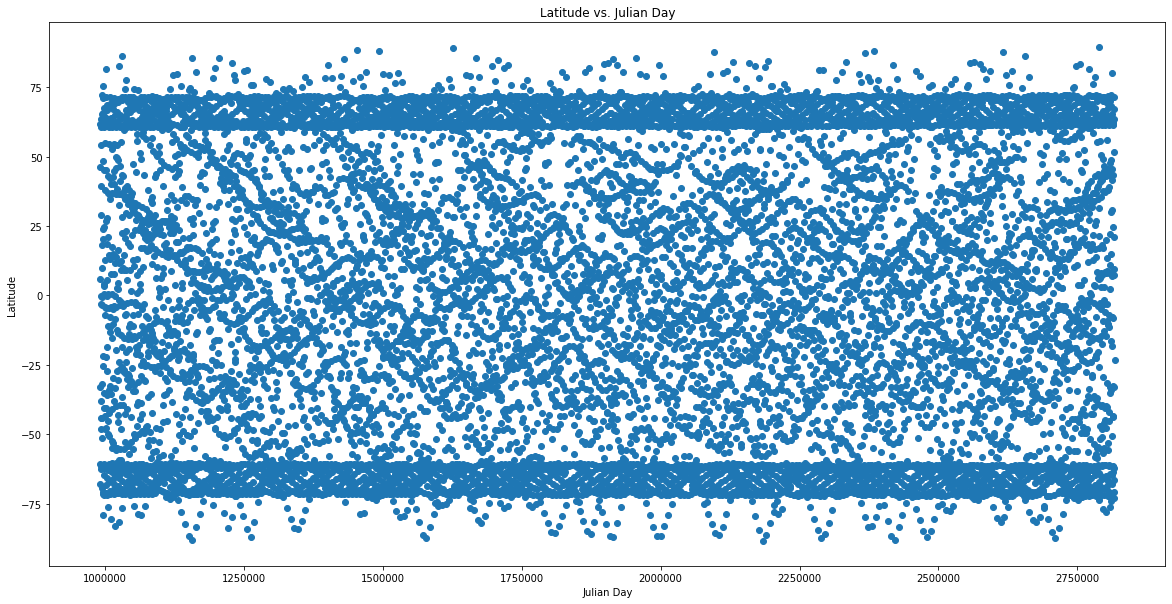

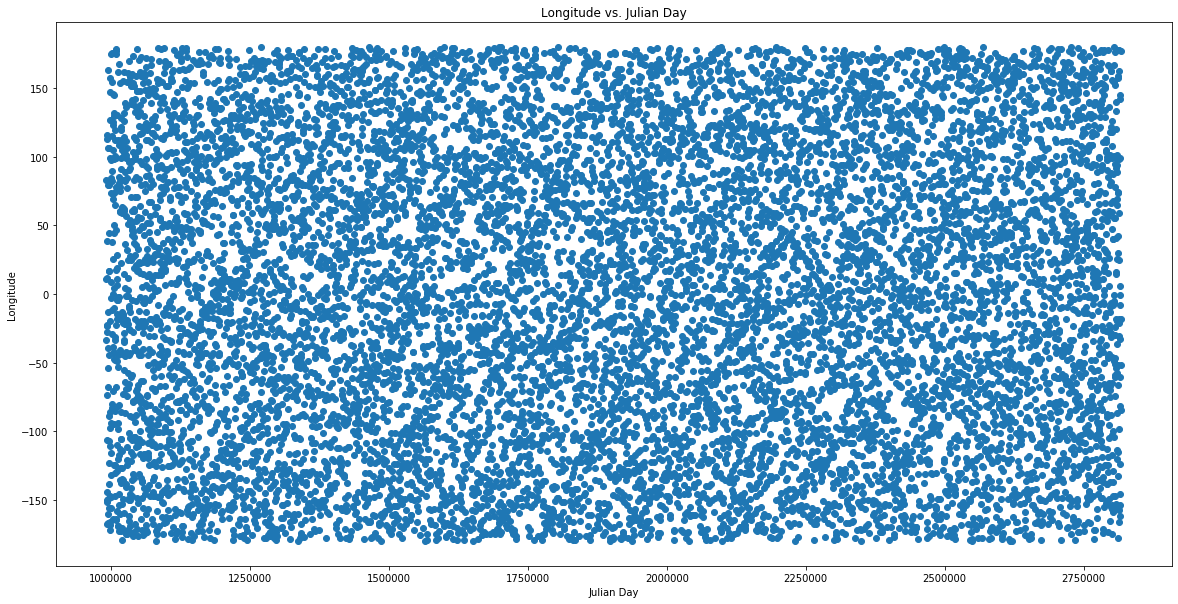

In [32]:
# Plot locations of all eclipses in dataset (~2000 BC to 3000 AD)
plot_locations(data)

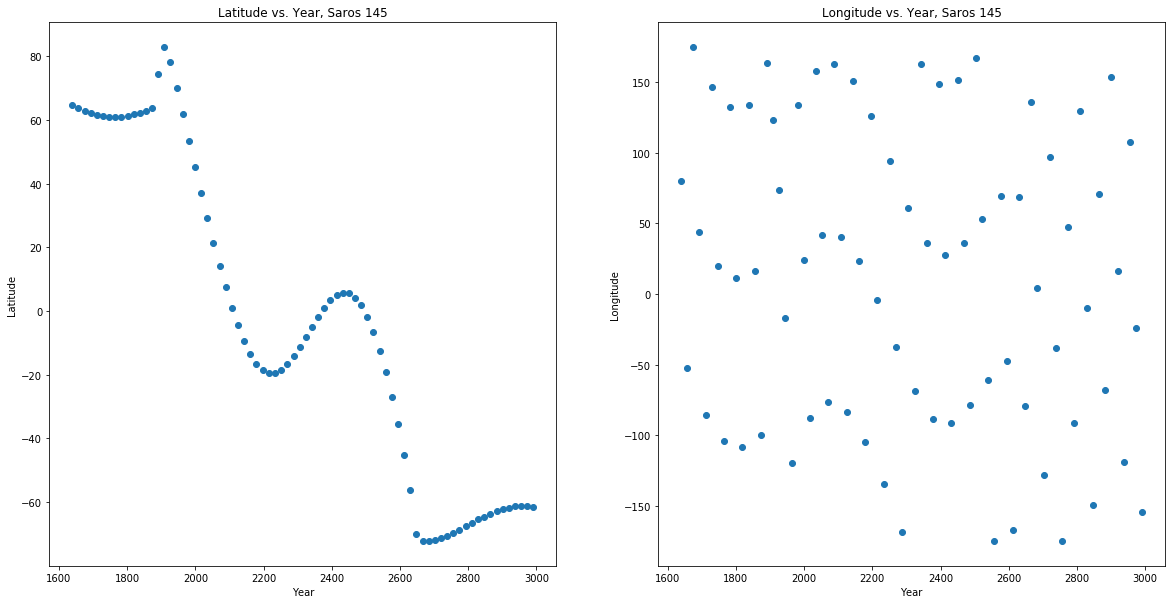

In [33]:
plot_saros(data, 145)

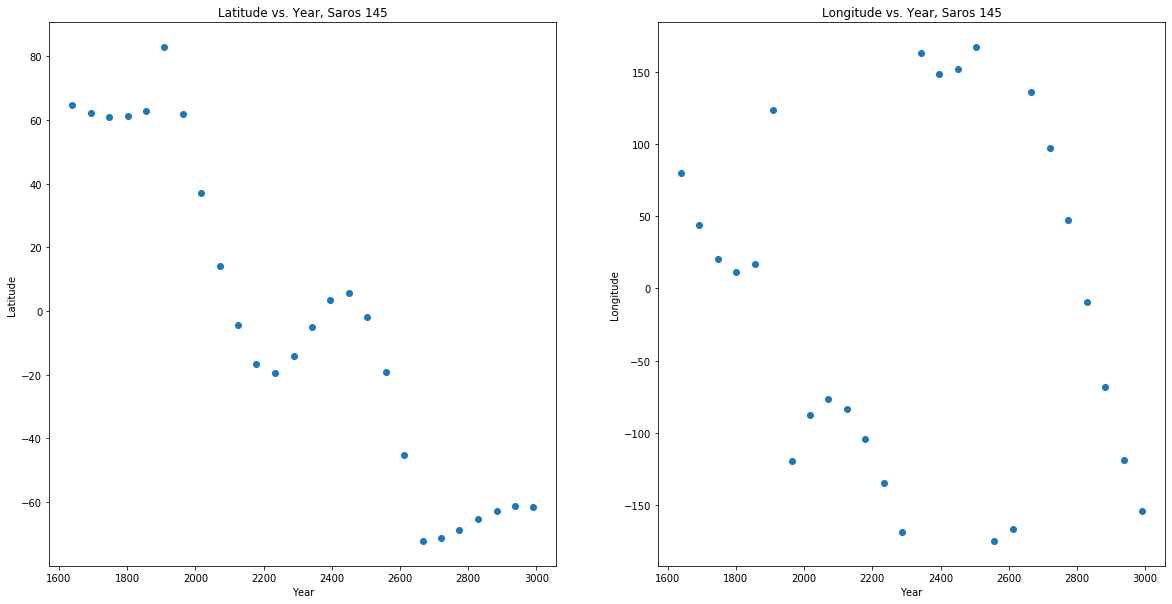

In [34]:
plot_saros_3rd_eclipses(data, 145)

As we can see, a pattern begins to emerge when we look at every 3rd eclipse in a given Saros. This makes sense, as the earth completes another 1/3 of a rotation for each Saros period. From [NASA's eclipse website](https://eclipse.gsfc.nasa.gov/SEsaros/SEperiodicity.html#section8): 
> Because the Saros period is not equal to a whole number of days, its biggest drawback as an eclipse predictor is that subsequent eclipses are visible from different parts of the globe. The extra 1/3 day displacement means that Earth must rotate an additional $\sim$8 hours or $\sim$120° with each cycle. For solar eclipses, this results in a shift of each succeeding eclipse path by $\sim$120° west. Thus, a Saros series returns to approximately the same geographic region every three Saros periods (~54 years and 34 days). This triple Saros cycle is known as the Exeligmos. 

This implies that we can exploit the periodicity of the Saros cycle for making our predictions. It will be much easier to predict a eclipse's longitude if we can:
1. Identify the Saros number $n$ it belongs to.
2. Identify the offset number $k \in \{0, 1, 2\}$ that corresponds to the set of longitude coordinates which repeat approximately every 3 Saros cycles (every Exeligmos).

In [35]:
data = pd.read_csv('solar_eclipse_data.csv')
data['ISO Date'] = data['Calendar Date'] + ' ' + data['Eclipse Time']
data['ISO Date'] = data['ISO Date'].apply(lambda x: to_isoformat(x))
data = data[data['Saros Number'] == 136]
data

,Catalog Number,Calendar Date,Eclipse Time,Delta T (s),Lunation Number,Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration,ISO Date
7999,8000,1360 June 14,05:56:04,378,-7910,136,Pb,-1.5227,0.0495,65.8S,78.2E,0,13,NaN,NaN,1360-6-14
8040,8041,1378 June 25,12:45:16,349,-7687,136,P,-1.4392,0.1976,64.8S,34.2W,0,23,NaN,NaN,1378-6-25
8081,8082,1396 July 5,19:37:40,323,-7464,136,P,-1.3568,0.3449,63.9S,147.2W,0,32,NaN,NaN,1396-7-5
8121,8122,1414 July 17,02:35:03,298,-7241,136,P,-1.2770,0.4881,63.1S,99.0E,0,42,NaN,NaN,1414-7-17
8161,8162,1432 July 27,09:39:02,274,-7018,136,P,-1.2011,0.6250,62.4S,16.3W,0,51,NaN,NaN,1432-7-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10813,10814,2550 June 16,07:45:35,1683,6808,136,P,1.1708,0.6840,66.4N,118.1W,0,352,NaN,NaN,2550-6-16
10853,10854,2568 June 26,14:58:55,1768,7031,136,P,1.2472,0.5426,65.5N,123.7E,0,342,NaN,NaN,2568-6-26
10893,10894,2586 July 7,22:07:07,1855,7254,136,P,1.3270,0.3957,64.5N,7.2E,0,332,NaN,NaN,2586-7-7
10934,10935,2604 July 19,05:14:31,1944,7477,136,P,1.4062,0.2509,63.7N,108.8W,0,323,NaN,NaN,2604-7-19


In [36]:
SAROS_LENGTH = 6585.32
JD_OFFSET = 2010506.5

def predict_saros(calendar_date, offset_to_saros_number):
    julian_day = to_jd(calendar_date.split())
    offset = (julian_day - JD_OFFSET) % SAROS_LENGTH
    min_diff = float('inf')
    saros = None
    for curr_offset in offset_to_saros_number:
        diff = abs(offset - curr_offset)
        if diff < min_diff:
            min_diff = diff
            saros = offset_to_saros_number[curr_offset]
    return saros

In [37]:
data = pd.read_csv('solar_eclipse_data.csv')
data = data[(117 <= data['Saros Number']) & (data['Saros Number'] < 157)] # Saros 117 through 157 are ongoing
prior_to_2020 = data['Calendar Date'].str.split().apply(lambda x: int(x[0]) <= 2020) # Select for years prior to 2020
data = data[prior_to_2020]

jds = []
for _, row in data.iterrows():
    jds.append(to_jd(row['Calendar Date'].split(), row['Eclipse Time']))

data['Julian Day'] = jds

active_saros = list(range(117, 157)) # Saros 117 through 157 are ongoing

saros_offsets = (data['Julian Day'] - JD_OFFSET) % SAROS_LENGTH
saros_table = pd.DataFrame({'Saros Number': data['Saros Number'], 'Saros Offset': saros_offsets})
offset_to_saros_number = {}
for _, row in saros_table.iterrows():
    saros = row['Saros Number']
    if saros in active_saros:
        active_saros.remove(saros)
        offset_to_saros_number[int(row['Saros Offset'])] = int(saros)

According to NASA, Saros 156 will have its first eclipse on 2011 Jul 01. So, we expect $n = 156$ and $k = k_0 (\text{mod }3)$ for the first eclipse. For the second eclipse on 2029 Jul 11, we expect $n = 156$ and $k = k_1 (\text{mod } 3) = k_0 + 1 (\text{mod } 3)$. For example: https://eclipse.gsfc.nasa.gov/SEsaros/SEsaros156.html

In [38]:
predict_saros('2011 July 1', offset_to_saros_number) # should be 156

156

In [39]:
def get_offset_in_saros(calendar_date, time):
    julian_day = to_jd(calendar_date.split(), time)
    return ((julian_day - JD_OFFSET) // SAROS_LENGTH) % 3

df = data[data['Saros Number'] == 155]

for _, row in df.iterrows():
    print(get_offset_in_saros(row['Calendar Date'], row['Eclipse Time']))

0.0
1.0
2.0
0.0
1.0
2.0


In [40]:
def get_eclipse_number(data, n, calendar_date, time):
    data = data[data['Saros Number'] == n]
    start = data.iloc[0]['Julian Day']
    jd = to_jd(calendar_date.split(), time)
    return (jd - start) // (SAROS_LENGTH - 0.1) # a small constant is needed for measurement inaccuracy, found empirically

In [41]:
def train_saros(data, n, k):
    """
    Train a model to predict longitude for Saros n and offset k.
    """
    data = data[data['Saros Number'] == n]
    if len(data) == 0:
        raise ValueError
    pd.options.mode.chained_assignment = None # handle false-positive warning. See https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
    
    ks = []
    for _, row in data.iterrows():
        ks.append(get_offset_in_saros(row['Calendar Date'], row['Eclipse Time']))
    data['k'] = ks
    pd.options.mode.chained_assignment = 'warn' # reset to default value
    
    data = data[data['k'] == k]
    data = data[['Longitude']]
    data['Longitude'] = data['Longitude'].apply(lambda x: convert_longitude(x))
    data['ISO Date'] = pd.date_range(start='1/1/1900', periods=len(data))

    data.rename(columns={'ISO Date': 'ds', 'Longitude': 'y'}, inplace=True)
    data['y'] = data['y']
    num_eclipses = len(data)
    if num_eclipses >= 16: # future work - tune the hyperparameters for Prophet
        prophet = fbprophet.Prophet(
                n_changepoints=4, changepoint_prior_scale=3, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False
            ).add_seasonality('daily', period=15, fourier_order=2)
    else:
        prophet = fbprophet.Prophet(changepoint_prior_scale=1, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False
            ).add_seasonality('daily', period=12, fourier_order=2)
    prophet.fit(data)
    # Each "day" corresponds to a Saros cycle (e.g. period of approx. 18 years).
    # We use days since pandas' datetime is limited to a smaller timespan than what we need.
    return prophet, num_eclipses

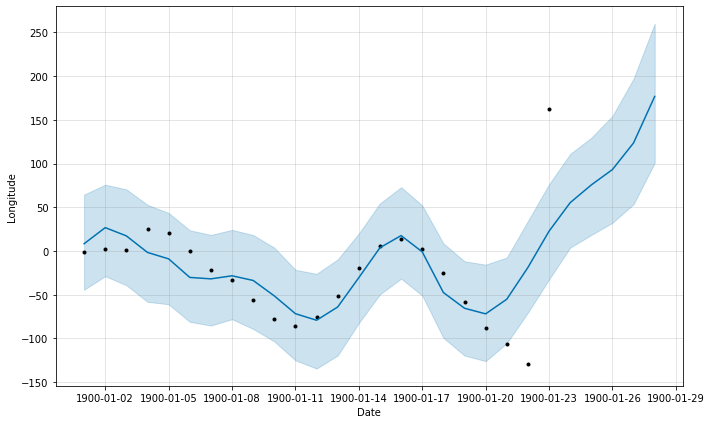

In [42]:
prophet, num_eclipses = train_saros(data, 118, 0)
forecast = prophet.make_future_dataframe(periods=5, freq='D')
forecast = prophet.predict(forecast)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    prophet.plot(forecast, xlabel='Date', ylabel='Longitude')

In [43]:
def mod_yhat(yhat):
    while True:
        if yhat > 180:
            yhat -= 360
        elif yhat < -180:
            yhat += 360
        else:
            break
    return yhat

INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


Predicted longitude: -119.7095405367124


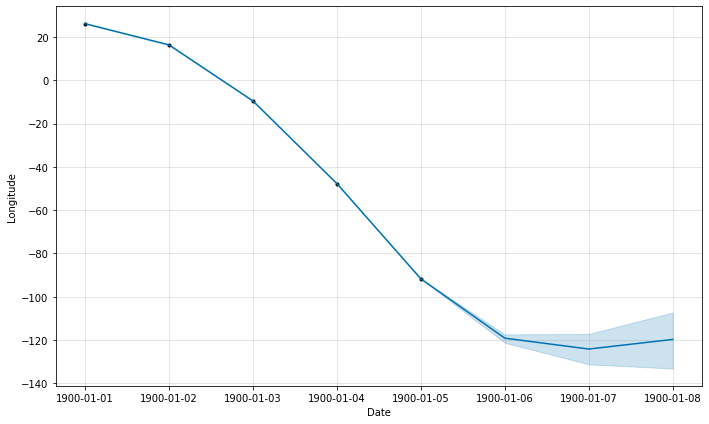

In [44]:
date = '2144 May 03'
time = '01:02:06'
n = predict_saros(date, offset_to_saros_number)
k = get_offset_in_saros(date, time)
eclipse_num = get_eclipse_number(data, n, date, time)
prophet, num_eclipses = train_saros(data, n, k)

num_periods = eclipse_num // 3 - num_eclipses + 1 # how many more eclipses to predict. Divide by 3 to account for the fact we trained on every 3 eclipses

forecast = prophet.make_future_dataframe(periods=int(num_periods), freq='D')
forecast = prophet.predict(forecast)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    prophet.plot(forecast, xlabel='Date', ylabel='Longitude')
pred = forecast.iloc[int(eclipse_num // 3)] # index into the predicted row
print('Predicted longitude:', mod_yhat(pred['yhat']))

Predicting eclipse longitude will still be a challenge, but a time series regression approach may help us. To see the finished command-line script, please run `predict_eclipse.py`.